# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from itertools import product
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
%matplotlib inline

# Config

In [3]:
DATA_FILE_PATHS = '/workspace/rahnemacollege/Project/Git/demand-prediction/data'
SHAPE_FILE_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/map_data/taxi_zones/taxi_zones.shp'
LR_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/lr_result.parquet'
XGB_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/XGB_result.parquet'
ARIMA_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/arima_output.xlsx'

PRED_RESULT_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/Pred_Result.csv'

start_date_test = '2023-04-01'
end_date_test = '2023-05-01'

# Load Data files

In [4]:
def load_data(file_paths):
    df = pd.read_parquet(file_paths).reset_index()
    df = df.rename(columns={'real demand': 'count',
                   'predicted demand': 'pred_count'})
    return df

In [5]:
lr_rides_df = load_data(LR_PATH)
print(lr_rides_df.shape)
lr_rides_df.head()

(8646, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,-0.0
1,2023-04-01,132,1,5,6059.0,5191.0,5678.0,5429.0
2,2023-04-01,165,1,5,3.0,3.0,2.0,4.0
3,2023-04-01,3,1,5,6.0,1.0,1.0,1.0
4,2023-04-01,147,1,5,2.0,1.0,4.0,2.0


In [6]:
xgb_rides_df = load_data(XGB_PATH)
print(xgb_rides_df.shape)
xgb_rides_df.head()

(8646, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,3.0
1,2023-04-01,132,1,5,6059.0,5191.0,5678.0,5374.0
2,2023-04-01,165,1,5,3.0,3.0,2.0,3.0
3,2023-04-01,3,1,5,6.0,1.0,1.0,3.0
4,2023-04-01,147,1,5,2.0,1.0,4.0,3.0


In [7]:
arima_rides_df = pd.read_excel(ARIMA_PATH, index_col=0)
arima_rides_df = arima_rides_df.rename(columns={'pred': 'pred_count'})
print(arima_rides_df.shape)
arima_rides_df.head()

(31178, 4)


,date,PULocationID,count,pred_count
0,2023-01-02,70,503,0
1,2023-01-03,70,530,500
2,2023-01-04,70,485,518
3,2023-01-05,70,417,488
4,2023-01-06,70,405,489


### Improved Data Bound Within Range: 2023-04-01 to 2023-04-30

For Model Evaluation

In [8]:
def df_time_bound(df):
    df['date'] = pd.to_datetime(df['date'])
    filtered_rides_df = df[(df['date'] >= start_date_test) & (
        df['date'] < end_date_test)]
    # Sort the DataFrame based on the 'tpep_pickup_datetime' column in ascending order
    filtered_rides_df = filtered_rides_df.sort_values(by='date')
    filtered_rides_df = filtered_rides_df.reset_index(drop=True)
    return filtered_rides_df

In [9]:
lr_rides_df = df_time_bound(lr_rides_df)
print(lr_rides_df.shape)
lr_rides_df.head()

(7860, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,-0.0
1,2023-04-01,180,1,5,4.0,3.0,1.0,4.0
2,2023-04-01,164,1,5,2735.0,2627.0,2896.0,2682.0
3,2023-04-01,144,1,5,1028.0,1486.0,1443.0,1413.0
4,2023-04-01,140,1,5,2415.0,1644.0,1653.0,1820.0


In [10]:
xgb_rides_df = df_time_bound(xgb_rides_df)
print(xgb_rides_df.shape)
xgb_rides_df.head()

(7860, 8)


,date,PULocationID,PU_day_of_month,PU_day_of_week,last_day_demand,last_week_demand,count,pred_count
0,2023-04-01,27,1,5,1.0,1.0,1.0,3.0
1,2023-04-01,180,1,5,4.0,3.0,1.0,3.0
2,2023-04-01,164,1,5,2735.0,2627.0,2896.0,2717.0
3,2023-04-01,144,1,5,1028.0,1486.0,1443.0,1379.0
4,2023-04-01,140,1,5,2415.0,1644.0,1653.0,1818.0


In [11]:
arima_rides_df = df_time_bound(arima_rides_df)
print(arima_rides_df.shape)
arima_rides_df.head()

(7860, 4)


,date,PULocationID,count,pred_count
0,2023-04-01,70,373,560
1,2023-04-01,190,4,1
2,2023-04-01,125,697,501
3,2023-04-01,151,954,818
4,2023-04-01,54,6,1


In [12]:
predictions_dict = {
    'baseline_last_day': None,
    'baseline_last_week': None,
    'arima': None,
    'model_regression': None,
    'model_xgboost': None
}

In [13]:
predictions_dict['baseline_last_day'] = xgb_rides_df[['date', 'PULocationID',
                                                      'last_day_demand']].rename(columns={'last_day_demand': 'pred_count'})

In [14]:
predictions_dict['baseline_last_week'] = xgb_rides_df[['date', 'PULocationID',
                                                       'last_week_demand']].rename(columns={'last_week_demand': 'pred_count'})

In [15]:
predictions_dict['arima'] = arima_rides_df[[
    'date', 'PULocationID', 'pred_count']]

In [16]:
predictions_dict['model_regression'] = lr_rides_df[[
    'date', 'PULocationID', 'pred_count']]

In [17]:
predictions_dict['model_xgboost'] = xgb_rides_df[[
    'date', 'PULocationID', 'pred_count']]

In [18]:
predictions_dict

{'baseline_last_day':            date  PULocationID  pred_count
 0    2023-04-01            27         1.0
 1    2023-04-01           180         4.0
 2    2023-04-01           164      2735.0
 3    2023-04-01           144      1028.0
 4    2023-04-01           140      2415.0
 ...         ...           ...         ...
 7855 2023-04-30            59         1.0
 7856 2023-04-30           176         1.0
 7857 2023-04-30            84         1.0
 7858 2023-04-30           136         1.0
 7859 2023-04-30             6         2.0
 
 [7860 rows x 3 columns],
 'baseline_last_week':            date  PULocationID  pred_count
 0    2023-04-01            27         1.0
 1    2023-04-01           180         3.0
 2    2023-04-01           164      2627.0
 3    2023-04-01           144      1486.0
 4    2023-04-01           140      1644.0
 ...         ...           ...         ...
 7855 2023-04-30            59         1.0
 7856 2023-04-30           176         1.0
 7857 2023-04-30          

# Report by Metrics

### Calculate metrics for all predictions model per all LocationIDs

In [19]:
PULocationIDs = xgb_rides_df['PULocationID'].unique()
PULocationIDs.sort()
metrics_all = []
for key in predictions_dict:
    for locationID in PULocationIDs:
        selected_df_model = predictions_dict[key][predictions_dict[key]
                                                  ['PULocationID'] == locationID]
        selected_df_actual = xgb_rides_df[xgb_rides_df['PULocationID'] == locationID]
        metric_mape = mean_absolute_percentage_error(
            selected_df_actual['count'], selected_df_model['pred_count'])
        metric_mae = mean_absolute_error(
            selected_df_actual['count'], selected_df_model['pred_count'])
        metric_mse = mean_squared_error(
            selected_df_actual['count'], selected_df_model['pred_count'])
        metric_rmse = mean_squared_error(
            selected_df_actual['count'], selected_df_model['pred_count'], squared=False)
        metric_r2sc = r2_score(
            selected_df_actual['count'], selected_df_model['pred_count'])
        metrics_all.append({'PULocationID': locationID, 'Model': key, 'MAPE': metric_mape,
                           'MAE': metric_mae, 'MSE': metric_mse, 'RMSE': metric_rmse, 'R2_score': metric_r2sc})


PULocationIDs_Metrics = pd.DataFrame(metrics_all)

In [20]:
print(PULocationIDs_Metrics.shape)
PULocationIDs_Metrics.head()

(1310, 7)


,PULocationID,Model,MAPE,MAE,MSE,RMSE,R2_score
0,1,baseline_last_day,0.365593,4.933333,37.400000,6.115554,-0.468843
1,2,baseline_last_day,0.033333,0.033333,0.033333,0.182574,-0.034483
2,3,baseline_last_day,0.818333,1.700000,5.566667,2.359378,-1.192560
3,4,baseline_last_day,0.702704,69.666667,8641.666667,92.960565,-0.149153
4,5,baseline_last_day,0.581111,1.133333,2.066667,1.437591,-1.299135


# Visualization

### Compare Models prediction vs. Last day count base on MAPE metric

In [21]:
def split_data_demand_metric(df, sorted_df, lower, upper, metrics):
    PULocationIDs_Metrics_High = sorted_df[sorted_df['PULocationID'].isin(
        df.iloc[lower:upper, 0])]
    PULocationIDs_Metrics_High = PULocationIDs_Metrics_High.copy()
    PULocationIDs_Metrics_High['PULocationID'] = PULocationIDs_Metrics_High['PULocationID'].astype(
        'str')
    plt.figure(figsize=(20, 5))
    sns.lineplot(data=PULocationIDs_Metrics_High,
                 x='PULocationID', y=metrics, hue='Model')
    plt.xticks(rotation=90)
    plt.title(f'Show Metric {metrics} For Location Id')
    plt.show()

In [22]:
# Prepare data for sorting based on demands count`
df = xgb_rides_df.groupby('PULocationID')[['count']].mean(
).sort_values('count', ascending=False).reset_index()
dummy = pd.Series(df['PULocationID']).to_frame()
sorted_df = pd.merge(dummy, PULocationIDs_Metrics,
                     on='PULocationID', how='left')

#### High Demand

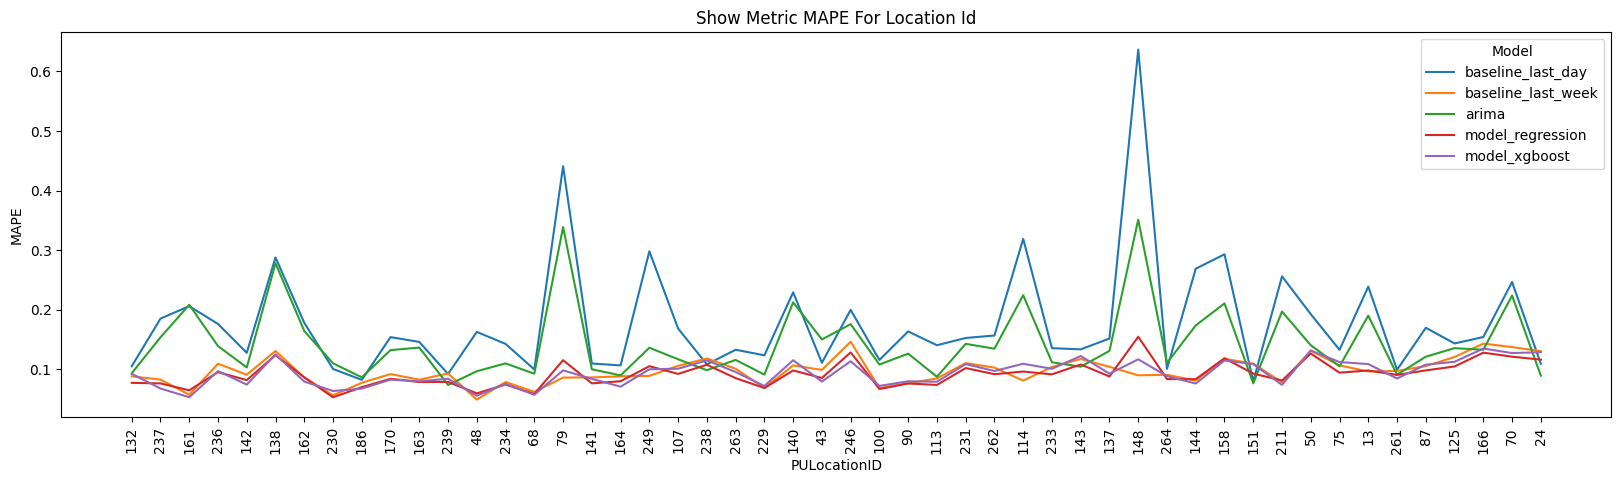

In [23]:
split_data_demand_metric(df, sorted_df, 0, 50, 'MAPE')

#### Mid Demand

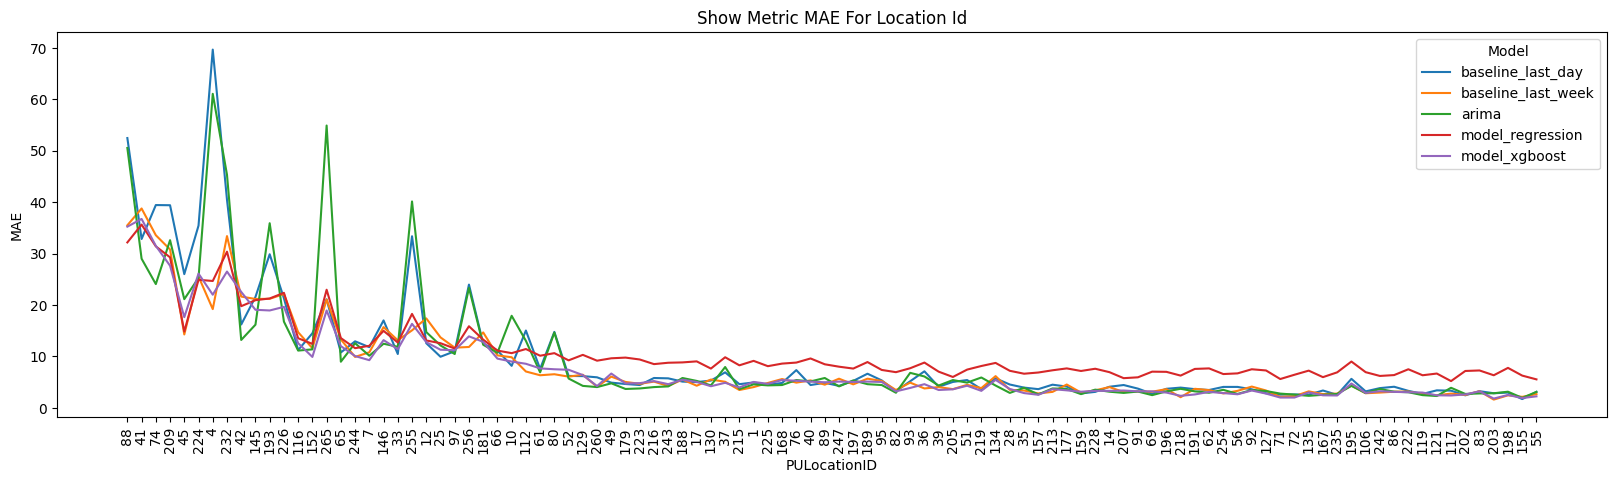

In [24]:
split_data_demand_metric(df, sorted_df, 50, 150, 'MAE')

#### Low Demand

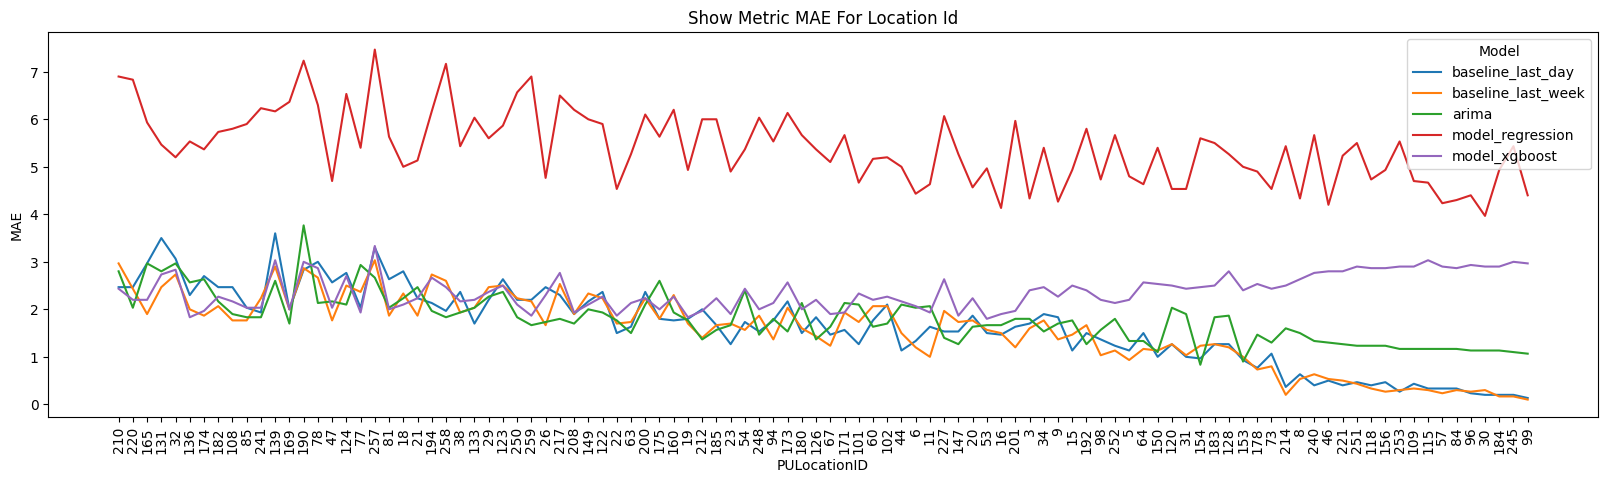

In [25]:
split_data_demand_metric(df, sorted_df, 150, 250, 'MAE')

### Compare Models predicion vs. Last day count based on actual count

In [26]:
def compare_model_scatter(actual_data, predictions_dict, lower_bound=0, upper_bound=262):
    selected_df_model = actual_data.groupby('PULocationID')[['count']].mean(
    ).sort_values('count', ascending=False).reset_index()

    selected_df_model = selected_df_model.iloc[lower_bound:upper_bound]

    plt.figure(figsize=(15, 5))
    plt.scatter(selected_df_model.index,
                selected_df_model['count'], label="Actual", color='red', s=15)
    for key in predictions_dict:
        sorted_df = pd.merge(
            selected_df_model['PULocationID'], predictions_dict[key], on='PULocationID', how='left')
        sorted_df = sorted_df.groupby('PULocationID')[['pred_count']].mean(
        ).sort_values('pred_count', ascending=False).reset_index()
        plt.plot(selected_df_model.index, sorted_df['pred_count'], label=key)

    plt.xticks(selected_df_model.index,
               selected_df_model['PULocationID'], rotation=90)

    plt.legend()
    plt.xlabel('PULocationID')
    plt.ylabel('Counts')
    plt.title('Demand count compare models predictions vs. actual')

    plt.show()

#### High Demand

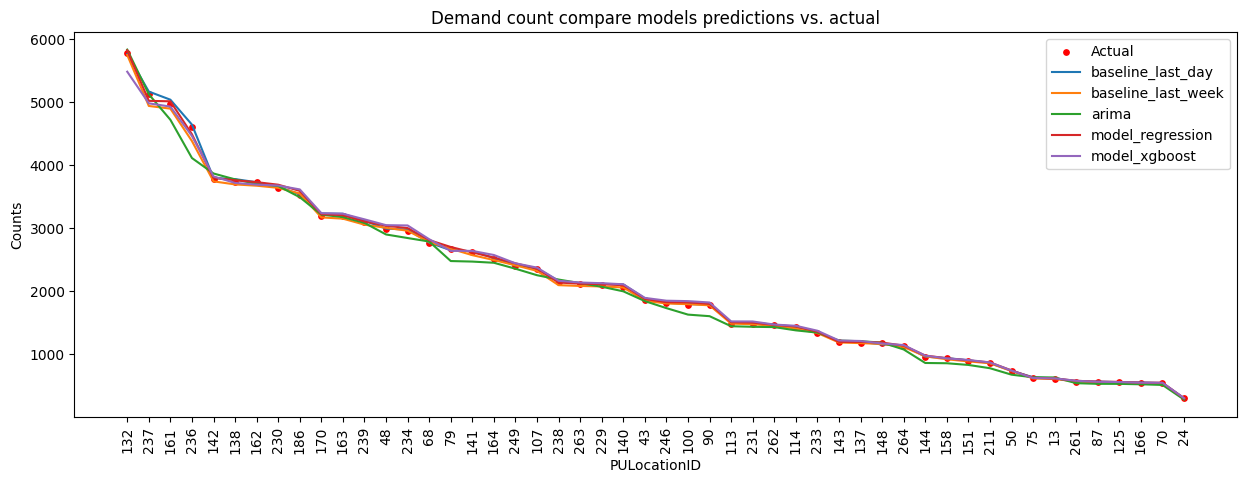

In [27]:
compare_model_scatter(xgb_rides_df, predictions_dict, 0, 50)

#### Mid Demand

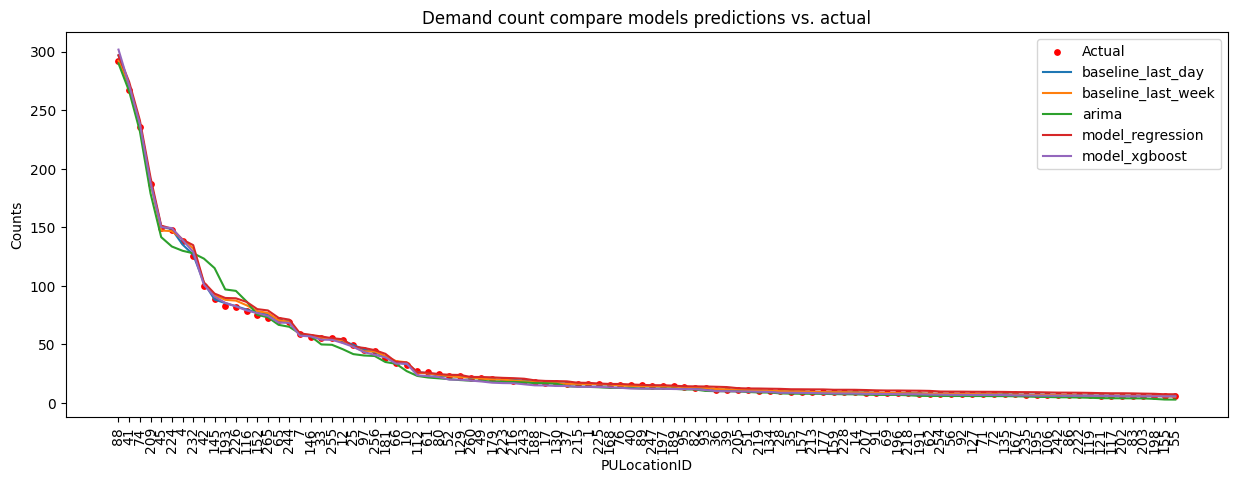

In [28]:
compare_model_scatter(xgb_rides_df, predictions_dict, 50, 150)

#### Low Demand

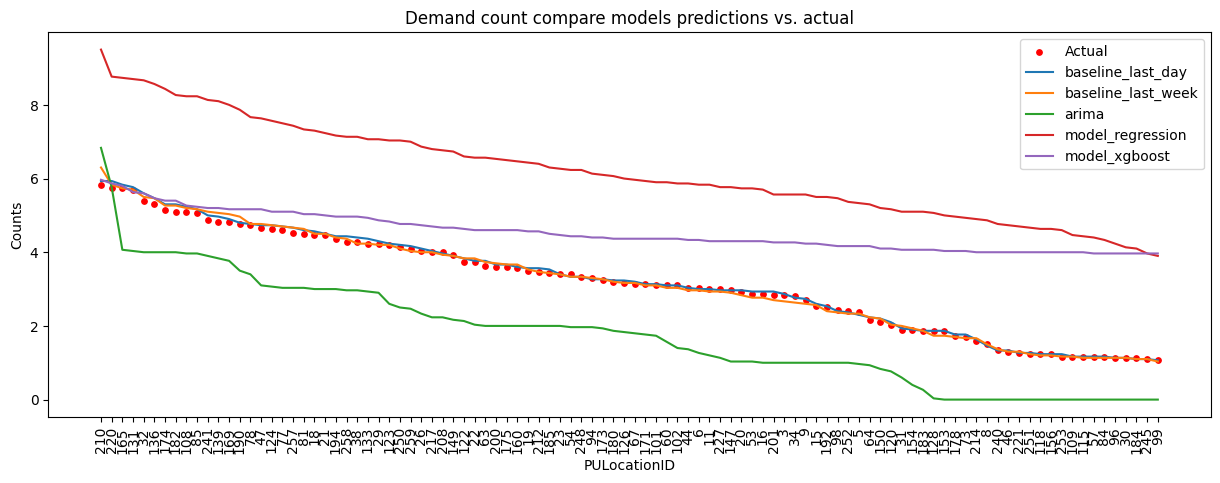

In [29]:
compare_model_scatter(xgb_rides_df, predictions_dict, 150, 250)

# Model prediction results in metrics

Metrics: MAPE, MAE, MSE, RMSE, R2Score

In [30]:
predictions_result = []
for key in predictions_dict:
    metric_mape = PULocationIDs_Metrics[PULocationIDs_Metrics['Model'] == key]['MAPE'].mean(
    )
    metric_mae = PULocationIDs_Metrics[PULocationIDs_Metrics['Model'] == key]['MAE'].mean(
    )
    metric_mse = PULocationIDs_Metrics[PULocationIDs_Metrics['Model'] == key]['MSE'].mean(
    )
    metric_rmse = PULocationIDs_Metrics[PULocationIDs_Metrics['Model'] == key]['RMSE'].mean(
    )
    metric_r2sc = PULocationIDs_Metrics[PULocationIDs_Metrics['Model'] == key]['R2_score'].mean(
    )
    predictions_result.append({'Model': key, 'MAPE': metric_mape, 'MAE': metric_mae,
                              'MSE': metric_mse, 'RMSE': metric_rmse, 'R2_score': metric_r2sc})

In [31]:
predictions_result = pd.DataFrame(predictions_result)
print(predictions_result.shape)
predictions_result.head()

(5, 6)


,Model,MAPE,MAE,MSE,RMSE,R2_score
0,baseline_last_day,0.463580,67.233333,46543.721374,81.688863,-0.616314
1,baseline_last_week,0.391069,39.754326,15026.578244,50.463495,-0.433727
2,arima,0.466219,59.025700,37490.706107,73.716861,-1.932118
3,model_regression,1.447700,39.729135,12663.365013,50.353842,-66.721967
4,model_xgboost,0.797557,37.779135,13297.872265,48.137538,-14.879088


In [32]:
predictions_result.to_csv(PRED_RESULT_PATH)